Settings: Signal To Noise Limit
===============================

This example demonstrates how to use set a signal-to-noise limit on the `Imaging` that is used to perform a
model-fit.

**Benefit:** Model fits can be subject to a bias whereby the over-fit the highest signal-to-noise regions of the image
instead of providing a global fit to the entire image. For example, if the lens galaxy has residual structure in its
centre that the lens light model cannot fit accurately, their high chi-squared contribution will drive the model
to place more light in those regions instead of providing a global fit to the overall image. Reducing the S/N of these
high S/N regions lessens over-fitting.

**Downside:** The noise-map of your data will no longer reflect the true noise properties of the data, which could
bias the lens model inferred and makes the estimation of reliable model-errors challenging.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Settings Specific Code__

To limit the signal-to-noise of the dataset used by the model-fit, we create a `SettingsImaging` object and 
specify that the `signal_to_noise_limit=10.0` and `signal_to_noise_limit_radii=0.5`. 

When the `Imaging` object is created, this will rescale the noise-map such that all image-pixels within 0.5" of 
the central pixel are increased so as to produce a signal-to-noise value in the data of 10.0. Image-pixels with a S/N
value below 10.0 do not have their noise-map value changed.

In [2]:
settings_imaging = al.SettingsImaging(
    signal_to_noise_limit=10.0, signal_to_noise_limit_radii=0.5
)

__Dataset__ 

For signal-to-noise limiting to be used in the model-fit, we must pass the `settings_imaging` to the 
`Imaging` object, which will rescale its noise-map accordingly.

In [3]:
dataset_name = "light_sersic_exp__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

imaging = imaging.apply_settings(
    settings=settings_imaging
)  # <----- The `SettingsImaging` above is used here!

__Masking__

The model-fit requires a `Mask2D` defining the regions of the image we fit the lens model to the data, which we define
and use to set up the `Imaging` object that the lens model fits.

In [4]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

A plot of the `Imaging` object reveals how the noise-map and signal-to-noise map have been rescaled.

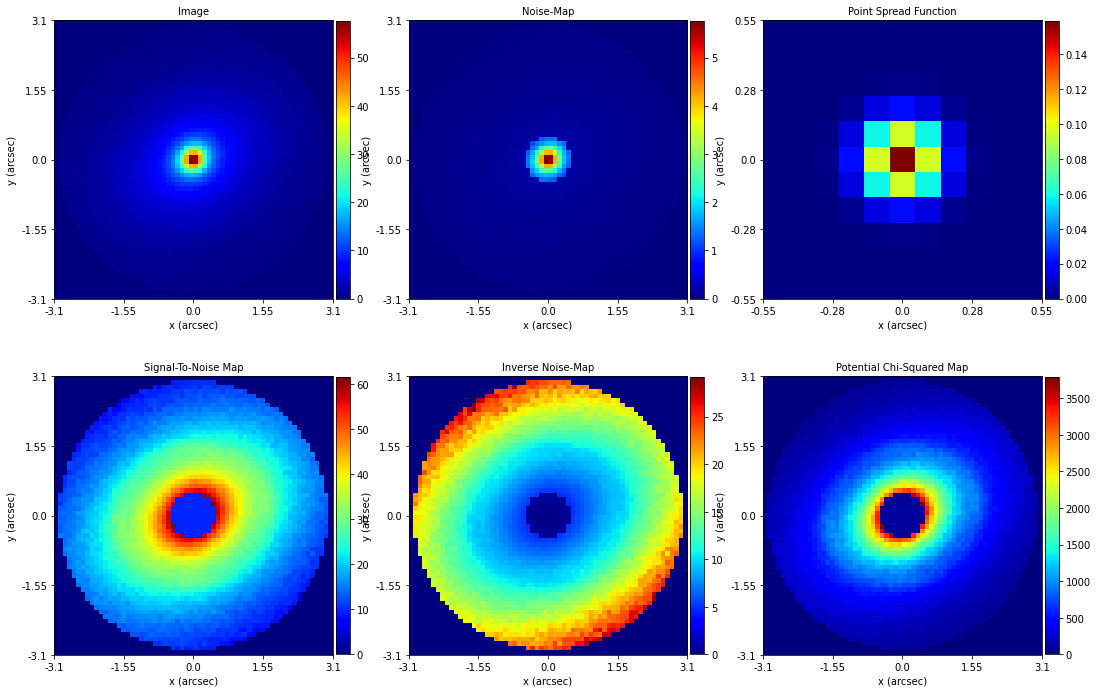

In [5]:
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Model + Search + Analysis__ 

The code below performs the normal steps to set up a model-fit. We omit comments of this code as you should be 
familiar with it and it is not specific to this example!

In [6]:
bulge = af.Model(al.lp.EllSersic)
disk = af.Model(al.lp.EllExponential)
bulge.centre = disk.centre

lens = af.Model(
    al.Galaxy,
    redshift=0.5,
    bulge=bulge,
    disk=disk,
    mass=al.mp.EllIsothermal,
    shear=al.mp.ExternalShear,
)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

search = af.DynestyStatic(
    path_prefix=path.join("imaging", "settings"),
    name="signal_to_noise_limit",
    unique_tag=dataset_name,
    nlive=100,
    walks=10,
)

analysis = al.AnalysisImaging(dataset=imaging)

__Model-Fit__

We can now begin the model-fit by passing the model and analysis object to the search, which performs a non-linear
search to find which models fit the data with the highest likelihood.

Because the `AnalysisImaging` was passed a `Imaging` with `signal_to_noise_limit=10.0` 
and `signal_to_noise_limit_radii=0.5` it fits the dataset with a rescaled signal-to-noise map.

In [7]:
result = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
2021-05-10 15:15:32,710 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  8.62it/s, +100 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.109]
2021-05-10 15:15:32,969 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:15:33,299 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 15:15:33,625 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


__Result__

By plotting the maximum log likelihood `FitImaging` object we can confirm the signal-to-noise map was rescaled.

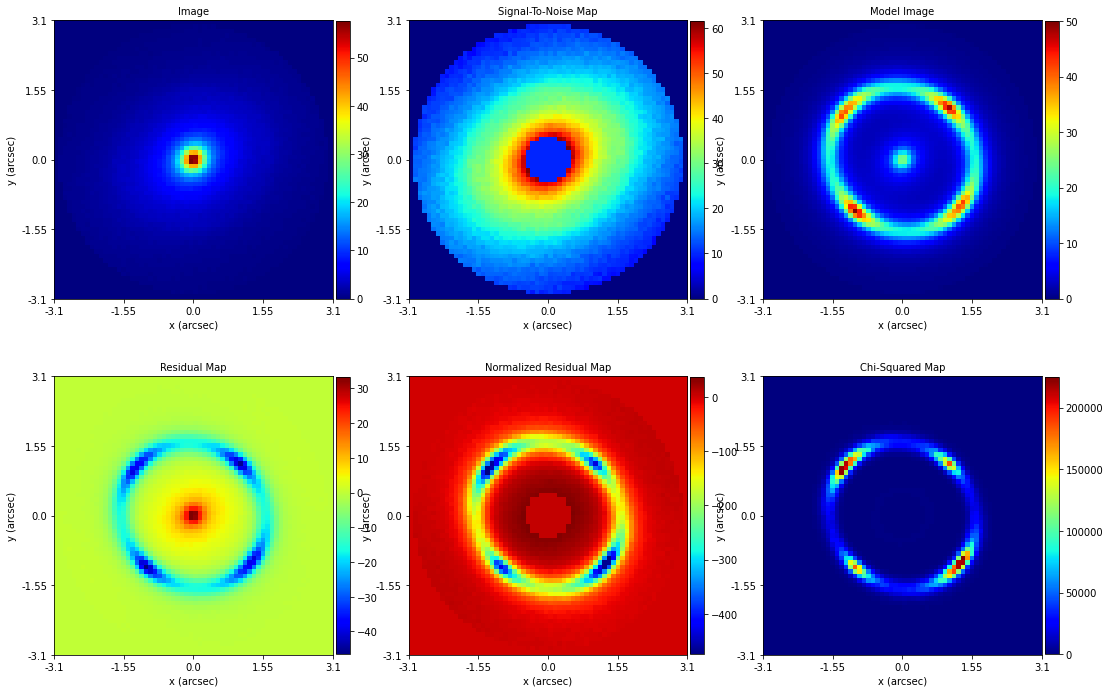

In [8]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

Finish.